In [3]:
import numpy as np
import pandas as pd
import cv2
import os
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50, DenseNet121

import tensorflow_hub as hub
import tensorflow as tf
import sklearn
from classification_models.keras import Classifiers

In [4]:
csv_file_path = '../DL_for_Hin_Chest_X_Ray/Data_Entry_2017_filtered_2.csv'
# csv_file_path = '../DL_for_Hin_Chest_X_Ray/HIN_archive/Data_Entry_2017.csv'
df = pd.read_csv(csv_file_path)

IMAGE_DIR = "../DL_for_Hin_Chest_X_Ray/HIN_archive/images/"
ALL_LABELS = sorted(df["Finding Labels"].str.split("|").explode().unique())
ALL_LABELS_WITHOUT_NO = [l for l in ALL_LABELS if l != "No Finding"]
NUMBER_CLASSES = len(ALL_LABELS)

def preprocess_image(file_path, image_size):
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None
    image = cv2.resize(image, (image_size, image_size))
    return image

def prepare_data(df, image_size, image_dir=IMAGE_DIR):
    images = []
    labels = []
    
    for _, row in tqdm(df.iterrows(), total=len(df)):
        image_path = os.path.join(image_dir, row["Image Index"])
        image = preprocess_image(image_path, image_size)
        
        if image is not None:
            images.append(image)

            current_label = np.zeros(NUMBER_CLASSES, dtype=int)
        
            if row["Finding Labels"] != "No Finding":
                indices = [i for i, label in enumerate(ALL_LABELS_WITHOUT_NO) if label in sorted(row["Finding Labels"].split("|"))]
                for idx in indices:
                    if 0 <= idx < NUMBER_CLASSES:
                        current_label[idx] = 1
            else:
                current_label[NUMBER_CLASSES - 1] = 1
            labels.append(current_label)
    
    images = np.array(images).reshape(-1, image_size, image_size)
    images = np.repeat(images[..., np.newaxis], 3, axis=-1) #rgb
    
    labels = np.array(labels)
    
    return images, labels

prepare_data(df[:100], 224)

100%|██████████| 100/100 [00:01<00:00, 84.26it/s]


KeyboardInterrupt: 

In [3]:
def create_resnet18_model(image_size):
    ResNet18, preprocess_input = Classifiers.get('resnet18')
    base_model = ResNet18(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    # base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    base_model.trainable = False
    
    model = Sequential()
    model.add(base_model)
    model.add(Conv2D(2048, (1, 1), activation='relu')) # Transition Layer
    model.add(GlobalAveragePooling2D())   
    model.add(Dense(NUMBER_CLASSES, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[AUC(multi_label=True)])
    return model

In [4]:
IMAGE_SIZE = 224
IMAGE_CENTER = (IMAGE_SIZE // 2, IMAGE_SIZE // 2)

def normalize_image(img, label):
    img = tf.cast(img, np.float32)# / 255.0
    img = tf.keras.applications.resnet.preprocess_input(img)
    return img, label

def create_train_dataset(images_train, labels_train, batch_size=16):
    train_dataset = tf.data.Dataset.from_tensor_slices((images_train, labels_train))
    train_dataset = train_dataset.map(normalize_image)
    train_dataset = train_dataset.shuffle(buffer_size=100)
    train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
    train_dataset = train_dataset.repeat()
    return train_dataset

def create_val_dataset(images_val, labels_val, batch_size=16):
    val_dataset = tf.data.Dataset.from_tensor_slices((images_val, labels_val))
    val_dataset = val_dataset.map(normalize_image)
    val_dataset = val_dataset.batch(batch_size, drop_remainder=False)
    return val_dataset

In [5]:
def evaluate_model(model, images_test, labels_test, batch_size=16):

    # images_test_2 = tf.cast(images_test, np.float32)
    images_test_2 = []
    
    for sample in images_test:
        images_test_2.append(normalize_image(sample, None)) 
    images_test_2 = np.array([tensor[0].numpy() for tensor in images_test_2])
    predictions = model.predict(images_test_2, batch_size=batch_size)
    
    
    auc_per_class = []
    for class_idx in range(NUMBER_CLASSES):
        true_labels_class = labels_test[:, class_idx]
        
        auc = sklearn.metrics.roc_auc_score(true_labels_class, predictions[:, class_idx])
        auc_per_class.append(auc)
        
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels_test, axis=1)
    balanced_accuracy = sklearn.metrics.balanced_accuracy_score(true_classes, predicted_classes)
    accuracy = sklearn.metrics.accuracy_score(true_classes, predicted_classes)
    
    binary_predicted_classes = np.where(predicted_classes < 3, 1, 0)
    binary_true_classes = np.where(true_classes < 3, 1, 0)
    conf_matrix = sklearn.metrics.confusion_matrix(binary_true_classes, binary_predicted_classes)  
    print(conf_matrix)
    
    return auc_per_class, balanced_accuracy, accuracy, conf_matrix

In [21]:
test_df = pd.read_csv('balancing/original.csv')
images_test, labels_test = prepare_data(test_df, IMAGE_SIZE)
with open(f"balancing/original.pkl", "wb") as file:
    pickle.dump((images_test, labels_test), file)
    
with open(f"balancing/original.pkl", "rb") as file:
    images_test, labels_test = pickle.load(file)
pass

python(30362) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 20000/20000 [05:23<00:00, 61.75it/s]


In [8]:
def evaluate_model(model, images_test, labels_test, batch_size=16):

    # images_test_2 = tf.cast(images_test, np.float32)
    images_test_2 = []
    
    for sample in images_test:
        images_test_2.append(normalize_image(sample, None)) 
    images_test_2 = np.array([tensor[0].numpy() for tensor in images_test_2])
    predictions = model.predict(images_test_2, batch_size=batch_size)
    
    
    auc_per_class = []
    for class_idx in range(NUMBER_CLASSES):
        true_labels_class = labels_test[:, class_idx]
        
        auc = sklearn.metrics.roc_auc_score(true_labels_class, predictions[:, class_idx])
        auc_per_class.append(auc)
        
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels_test, axis=1)
    balanced_accuracy = sklearn.metrics.balanced_accuracy_score(true_classes, predicted_classes)
    accuracy = sklearn.metrics.accuracy_score(true_classes, predicted_classes)
    
    binary_predicted_classes = np.where(predicted_classes < 3, 1, 0)
    binary_true_classes = np.where(true_classes < 3, 1, 0)
    conf_matrix = sklearn.metrics.confusion_matrix(binary_true_classes, binary_predicted_classes)  
    print(conf_matrix)
    
    return auc_per_class, balanced_accuracy, accuracy, conf_matrix





master_evaluations = {}
BATCH_SIZE = 16
IMAGE_SIZE = 224

with open(f"balancing/testing.pkl", "rb") as file:
    images_test, labels_test = pickle.load(file)


for bal_idx in [1]:
    
    evaluations = {}
    
    images = None
    labels = None
    if bal_idx == 0 or bal_idx >= 3:
        with open(f"balancing/original.pkl", "rb") as file:
            images, labels = pickle.load(file)  
    if bal_idx == 1:
        with open(f"balancing/3333Finding10kNofinding.pkl", "rb") as file:
            images, labels = pickle.load(file)
    if bal_idx == 2:
        with open(f"balancing/5keach.pkl", "rb") as file:
            images, labels = pickle.load(file)
           
            
    for run in range(0, 5):
    
        tf.keras.backend.clear_session()
           
        images_train, images_val, labels_train, labels_val = sklearn.model_selection.train_test_split(images, labels, random_state=42, test_size=0.2, stratify=labels)
            
        train_dataset = create_train_dataset(images_train, labels_train)
        val_dataset = create_val_dataset(images_val, labels_val)        
        steps_per_epoch = len(images_train) // BATCH_SIZE
        validation_steps = len(images_val) // BATCH_SIZE
        
        
        
        class_weight_dict = {}
        if bal_idx == 3:
            class_weights = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels_train.argmax(axis=1)), y=labels_train.argmax(axis=1))
            class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
        elif bal_idx == 4: 
            class_weight_dict = {0: 2, 1: 2, 2: 2, 3: 1}
        else: 
            unique_classes = np.unique(labels_train.argmax(axis=1))
            class_weight_dict = {class_label: 1 for class_label in unique_classes}

                
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            
        model = create_resnet18_model(IMAGE_SIZE)
                            
        model.fit(
            train_dataset,
            steps_per_epoch=steps_per_epoch,
            epochs=20,
            validation_data=val_dataset,
            validation_steps=validation_steps,
            batch_size=BATCH_SIZE,
            verbose=1,
            callbacks=[early_stopping],
            class_weight=class_weight_dict) #######BIRNE
        
        sub_eval = evaluate_model(model, images_test, labels_test)
        
        evaluations[run] = sub_eval
        print(bal_idx)
        print(evaluations)
        
    master_evaluations[bal_idx] = evaluations

Epoch 1/20
999/999 ━━━━━━━━━━━━━━━━━━━━ 62s 56ms/step - auc: 0.6544 - loss: 1.3133 - val_auc: 0.7315 - val_loss: 1.0943
Epoch 2/20
999/999 ━━━━━━━━━━━━━━━━━━━━ 52s 53ms/step - auc: 0.7291 - loss: 1.0722 - val_auc: 0.7435 - val_loss: 1.0703
Epoch 3/20
999/999 ━━━━━━━━━━━━━━━━━━━━ 52s 52ms/step - auc: 0.7456 - loss: 1.0474 - val_auc: 0.7476 - val_loss: 1.0600
Epoch 4/20
999/999 ━━━━━━━━━━━━━━━━━━━━ 51s 51ms/step - auc: 0.7637 - loss: 1.0184 - val_auc: 0.7482 - val_loss: 1.0621
Epoch 5/20
999/999 ━━━━━━━━━━━━━━━━━━━━ 51s 51ms/step - auc: 0.7786 - loss: 0.9888 - val_auc: 0.7491 - val_loss: 1.0668
Epoch 6/20
999/999 ━━━━━━━━━━━━━━━━━━━━ 52s 52ms/step - auc: 0.7959 - loss: 0.9595 - val_auc: 0.7450 - val_loss: 1.0979
Epoch 7/20
999/999 ━━━━━━━━━━━━━━━━━━━━ 51s 51ms/step - auc: 0.8142 - loss: 0.9220 - val_auc: 0.7409 - val_loss: 1.0999
Epoch 8/20
999/999 ━━━━━━━━━━━━━━━━━━━━ 51s 51ms/step - auc: 0.8357 - loss: 0.8716 - val_auc: 0.7389 - val_loss: 1.1332
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/st

KeyboardInterrupt: 

In [ ]:
# training everything
evaluations_all_weights = {0: ([0.6931266013735805, 0.816195260868994, 0.5180566726299648, 0.674347269584824], 0.3375533216371229, 0.575, np.array([[2022,  730],
       [ 583,  665]])), 1: ([0.727793022938492, 0.8225001970805795, 0.5706152845846237, 0.6861977710848988], 0.31264532596776257, 0.51775, np.array([[1714, 1038],
       [ 425,  823]]))}
evaluations_all_weights = {0: ([0.7384473688200246, 0.8269837802682924, 0.5851113608346613, 0.6968801244782348], 0.35451934891943315, 0.60825, np.array([[2152,  600],
       [ 630,  618]])), 1: ([0.6725977501174971, 0.7994458751034673, 0.5842427049821101, 0.6719260992005814], 0.3206294063335773, 0.422, np.array([[1235, 1517],
       [ 313,  935]])), 2: ([0.7256344850589003, 0.820475194124371, 0.5887865878408851, 0.6897642332382976], 0.3665171972963187, 0.5435, np.array([[1802,  950],
       [ 446,  802]])), 3: ([0.7150767901272002, 0.798472789741299, 0.5500752615833308, 0.6726221256335718], 0.3159034488221557, 0.62925, np.array([[2297,  455],
       [ 749,  499]])), 4: ([0.6838229998938734, 0.7975341934805744, 0.5364372707387474, 0.6802424576997614], 0.3357246754065273, 0.59225, np.array([[2093,  659],
       [ 599,  649]]))}

evaluations_double_disease = {0: ([0.7447003062508527, 0.8099921496235761, 0.6034658851739378, 0.7014739571686792], 0.3750540604841636, 0.676, np.array([[2442,  310],
       [ 810,  438]]))}
evaluations_double_disease = {0: ([0.7345424809351264, 0.8152739091589914, 0.5730549437746173, 0.6916968312090042], 0.32559286675698973, 0.662, np.array([[2444,  308],
       [ 859,  389]])), 1: ([0.7382436437787111, 0.8362211112716953, 0.587518134189242, 0.6959213229539357], 0.27770647093821266, 0.689, np.array([[2678,   74],
       [1116,  132]])), 2: ([0.7377537561212268, 0.8349351604892855, 0.5730981651583029, 0.6998150529218843], 0.31320587952339235, 0.685, np.array([[2590,  162],
       [ 997,  251]])), 3: ([0.7650320653739444, 0.8227933544428533, 0.5838311622417992, 0.6927939354129398], 0.33177558324457385, 0.672, np.array([[2489,  263],
       [ 905,  343]])), 4: ([0.6952121772616324, 0.7942905756066798, 0.5679069011395411, 0.6898365873770125], 0.28299786576390934, 0.6765, np.array([[2584,  168],
       [ 986,  262]]))}


evaluations_original = {0: ([0.7175385466729332, 0.8286655345482256, 0.5801531164496828, 0.6965896888509988], 0.2723443219078847, 0.69, np.array([[2709,   43],
       [1175,   73]]))}
evaluations_original = {0: ([0.7444027729347018, 0.8186398812261039, 0.5554267266003188, 0.6961155290324985], 0.24990915697674418, 0.68775, np.array([[2751,    1],
       [1247,    1]])), 1: ([0.7136023893630892, 0.8001742520792002, 0.5820924411437506, 0.6843813473650865], 0.3094084000854759, 0.6875, np.array([[2626,  126],
       [1053,  195]])), 2: ([0.7340677542109493, 0.8146145103861465, 0.5756947367629814, 0.7074378598781307], 0.2736544730955024, 0.69075, np.array([[2691,   61],
       [1126,  122]])), 3: ([0.7187447884291757, 0.8120368606377527, 0.5611996001082413, 0.6990254174120454], 0.26869968374380654, 0.689, np.array([[2697,   55],
       [1135,  113]])), 4: ([0.7568233675465061, 0.8352751244892327, 0.5620095312546979, 0.7032384081973018], 0.2804657048121837, 0.689, np.array([[2710,   42],
       [1181,   67]]))}

evaluations_3_10 = {0: ([0.7367815612729121, 0.8310378920261197, 0.5585095387714604, 0.6955611536598092], 0.35469890627315825, 0.663, np.array([[2451,  301],
       [ 891,  357]])), 1: ([0.7041144877878682, 0.8266035789833269, 0.5775706387744671, 0.6922421805120751], 0.3574627938453845, 0.6125, np.array([[2134,  618],
       [ 629,  619]])), 2: ([0.7473004063130128, 0.8223359632641799, 0.5676024722631468, 0.6937975761217949], 0.32494527251632377, 0.67975, np.array([[2577,  175],
       [ 994,  254]])), 3: ([0.7072158462074927, 0.8093483530632892, 0.5714223969451877, 0.6870399616129994], 0.34908331167266304, 0.5995, np.array([[2097,  655],
       [ 673,  575]])), 4: ([0.7104479676768902, 0.8332878953107961, 0.5638455004660392, 0.7017344029516994], 0.38170367350845996, 0.60075, np.array([[2067,  685],
       [ 573,  675]]))}

evaluations_equally = {0: ([0.729862490334905, 0.8281243841231886, 0.5988858278962085, 0.6998965787119857], 0.43959303401147864, 0.534, np.array([[1702, 1050],
       [ 401,  847]])), 1: ([0.7132044148637791, 0.8153445297000433, 0.5812021745993565, 0.6823641663871498], 0.4204599010773573, 0.55225, np.array([[1780,  972],
       [ 457,  791]])), 2: ([0.6632624054336784, 0.8184698992261303, 0.5790500315704019, 0.6906000181686047], 0.43517969266591927, 0.5065, np.array([[1595, 1157],
       [ 368,  880]])), 3: ([0.7410076714322533, 0.8430253182851362, 0.5950760038636158, 0.6875331926431127], 0.4154807803514805, 0.523, np.array([[1638, 1114],
       [ 413,  835]])), 4: ([0.7205233554177596, 0.8275191825097554, 0.6131662670254667, 0.6959903287119857], 0.4170124447661493, 0.52875, np.array([[1614, 1138],
       [ 371,  877]]))}

In [50]:
# Only last layers are trained from scratch

evaluations_3_10_cw_2 = {0: ([0.7356833411664823, 0.8096792842033346, 0.5986885128837307, 0.6887563706581694], 0.39523561647142913, 0.6355, array([[2247,  505],
       [ 706,  542]])), 1: ([0.7358396882912113, 0.8214228232449974, 0.6042020580895398, 0.6977492476334228], 0.4254987510612672, 0.6085, array([[2077,  675],
       [ 594,  654]])), 2: ([0.7283094422292635, 0.8197230032452602, 0.600199147223308, 0.6959414132379249], 0.42441230521132156, 0.608, array([[2079,  673],
       [ 583,  665]])), 3: ([0.7421959095801938, 0.8220296671965944, 0.5932134910851198, 0.6967164905709601], 0.4266043291937626, 0.6085, array([[2099,  653],
       [ 593,  655]])), 4: ([0.719473460786246, 0.816788966115279, 0.6014795807149944, 0.6935672657647585], 0.3986701013963519, 0.62025, array([[2164,  588],
       [ 643,  605]]))}

evaluations_original = {0: ([0.7604212465319364, 0.8233410742205464, 0.5848210258877297, 0.694629430344365], 0.27189603645668925, 0.68975, np.array([[2708,   44],
       [1167,   81]])), 1: ([0.7602137312572962, 0.8305788585092825, 0.5892479291319643, 0.6969214697003577], 0.268820130212167, 0.68775, np.array([[2716,   36],
       [1191,   57]])), 2: ([0.7528928955866523, 0.8287755712052134, 0.5962859677079888, 0.6949019594141325], 0.27080343693035563, 0.6845, np.array([[2702,   50],
       [1186,   62]])), 3: ([0.7383729854909868, 0.8127496354009276, 0.5874918255209116, 0.6876415054785331], 0.2844228315259279, 0.68925, np.array([[2687,   65],
       [1129,  119]])), 4: ([0.7465546779059719, 0.8161927973617482, 0.5928912098980726, 0.6903863041331246], 0.2951653900202592, 0.687, np.array([[2661,   91],
       [1098,  150]]))}

evaluations_3_10 = {0: ([0.7332206370624176, 0.8234264758050742, 0.5937417785411467, 0.694618074966458], 0.35366828353290936, 0.6585, np.array([[2410,  342],
       [ 843,  405]])), 1: ([0.7330595521460302, 0.8186595892840719, 0.5959993911422472, 0.6924042130199016], 0.36108751510195236, 0.663, np.array([[2443,  309],
       [ 860,  388]])), 2: ([0.7235394335875317, 0.8180962672938209, 0.594933890074867, 0.6921594900678295], 0.338205560014586, 0.65775, np.array([[2425,  327],
       [ 860,  388]])), 3: ([0.7249901453933505, 0.8100627701646281, 0.5993781758321056, 0.6881091141174717], 0.3857053899845423, 0.64875, np.array([[2329,  423],
       [ 779,  469]])), 4: ([0.7371567943722617, 0.8176199892262618, 0.6007744144442106, 0.6934301277392666], 0.36573050628028414, 0.66125, np.array([[2422,  330],
       [ 851,  397]]))}

evaluations_equally = {0: ([0.7231405115298899, 0.7841458527676682, 0.5700388428695993, 0.679138074407424], 0.42671050079542594, 0.473, np.array([[1437, 1315],
       [ 335,  913]])), 1: ([0.705982125259631, 0.7666968309442788, 0.5763346011605881, 0.6736312984496123], 0.3791119388187444, 0.44775, np.array([[1333, 1419],
       [ 327,  921]])), 2: ([0.7307806743583134, 0.8032462456149572, 0.5645685190474758, 0.6829898768261777], 0.42964012921927397, 0.50725, np.array([[1593, 1159],
       [ 385,  863]])), 3: ([0.7136203929713912, 0.7752870807110666, 0.5770266130972068, 0.6858648255813954], 0.40927839379811076, 0.42675, np.array([[1213, 1539],
       [ 271,  977]])), 4: ([0.7182624812383449, 0.794768496012403, 0.5657566373011816, 0.6790798417002086], 0.40187919445947085, 0.50925, np.array([[1624, 1128],
       [ 420,  828]]))}

#with class weights
evaluations_original_cw = {0: ([0.7285207477372309, 0.8253184493699991, 0.5869576655942753, 0.694900794759988], 0.446495495307508, 0.5505, np.array([[1817,  935],
       [ 459,  789]])), 1: ([0.7334707924619839, 0.807035119759299, 0.5854613600829851, 0.6922436363297555], 0.4251975300070245, 0.499, np.array([[1621, 1131],
       [ 380,  868]])), 2: ([0.7233063342379357, 0.8231464571481126, 0.5777665443939987, 0.6870725719290399], 0.42924335505043054, 0.50375, np.array([[1650, 1102],
       [ 419,  829]])), 3: ([0.7433102381782623, 0.8223593665830169, 0.5985677748880003, 0.6951392576960347], 0.4386069124437315, 0.50925, np.array([[1616, 1136],
       [ 386,  862]])), 4: ([0.7077592709107172, 0.7993563676735295, 0.5960200622387926, 0.6945968200283243], 0.4398427447590284, 0.54325, np.array([[1771,  981],
       [ 428,  820]]))}

evaluations_3_10_cw = {0: ([0.7125998726481603, 0.7719112546149701, 0.6098922472112811, 0.6882392642180979], 0.3994763695954361, 0.56475, np.array([[1872,  880],
       [ 494,  754]])), 1: ([0.7237043087372459, 0.815595807439135, 0.6013466279803963, 0.6912102969402207], 0.43340867783139425, 0.577, np.array([[1904,  848],
       [ 503,  745]])), 2: ([0.702076289816401, 0.7494021889083049, 0.5932214776451488, 0.6845403226557841], 0.3810901244980211, 0.6005, np.array([[2051,  701],
       [ 580,  668]])), 3: ([0.7295327400354766, 0.8126207118550537, 0.604226487567275, 0.6958645460644006], 0.4068588119909058, 0.55575, np.array([[1836,  916],
       [ 476,  772]])), 4: ([0.7198420609772738, 0.8007080119824992, 0.6058388330978081, 0.695514567494037], 0.39045801732961444, 0.57775, np.array([[1935,  817],
       [ 505,  743]]))}

evaluations_equally_cw = {0: ([0.7317339180399944, 0.7988850166204622, 0.5860030367720016, 0.6859138866372242], 0.42042839490208844, 0.53625, np.array([[1749, 1003],
       [ 438,  810]])), 1: ([0.7195426325444595, 0.7954927671427257, 0.5645274117532096, 0.6844643289728681], 0.41216914357709045, 0.4885, np.array([[1512, 1240],
       [ 372,  876]])), 2: ([0.7266606907321215, 0.7969577327850114, 0.560422084999549, 0.6837052656343172], 0.4252001096493967, 0.5245, np.array([[1721, 1031],
       [ 421,  827]])), 3: ([0.7230069058051214, 0.8017229769678497, 0.5720646103310382, 0.6881225076401312], 0.4338782127451498, 0.54725, np.array([[1799,  953],
       [ 449,  799]])), 4: ([0.7309351263663791, 0.7864245969702145, 0.5738272911091735, 0.6841996613185748], 0.39988538086960823, 0.4755, np.array([[1439, 1313],
       [ 346,  902]]))}

# class weights 2 - 1

evaluations_original_cw_2 = {0: ([0.7420428789096256, 0.822827843544297, 0.5863852171592652, 0.6876645073978832], 0.34388839313010433, 0.66275, np.array([[2455,  297],
       [ 895,  353]])), 1: ([0.7215760927242681, 0.8135182496616783, 0.5843206913918038, 0.6843557249739117], 0.3405652106023467, 0.638, np.array([[2326,  426],
       [ 785,  463]])), 2: ([0.7511801839021209, 0.8228721866747251, 0.5924171840704772, 0.6951375107148181], 0.2988691831694884, 0.68, np.array([[2599,  153],
       [1018,  230]])), 3: ([0.7581224700192545, 0.8244775722300326, 0.592073761989236, 0.6954873437034139], 0.29785796374985696, 0.684, np.array([[2621,  131],
       [1052,  196]])), 4: ([0.7592765960672538, 0.8237064944620357, 0.5954807345380198, 0.6962884801729279], 0.29572304157578627, 0.6815, np.array([[2609,  143],
       [1039,  209]]))}

In [2]:
evaluations_original = {0: ([0.7555346882154066, 0.794719225867483, 0.5810687520671096, 0.6944914188282647], 0.25847951805012215, 0.6895), 1: ([0.752866363953365, 0.8025195109773882, 0.585957936197721, 0.6890460783765653], 0.2568474331532784, 0.68975), 2: ([0.7488117618520596, 0.79049841678601, 0.5781813757178508, 0.6872035955202743], 0.2691677947808307, 0.6875), 3: ([0.7383668263618309, 0.7911939469984627, 0.5783645968008659, 0.685570022501118], 0.25815125289943996, 0.689), 4: ([0.748684789035613, 0.7901182155010444, 0.5861294123395171, 0.6881262927661003], 0.26744817805221477, 0.68925)}

evaluations_3_10 = {0: ([0.7342856926272382, 0.8246056746068243, 0.6019211905048257, 0.6982145269640727], 0.3649495935070578, 0.66475), 1: ([0.7416719098227688, 0.8157009170816308, 0.6017093117652365, 0.6943630157088552], 0.35063759927775134, 0.66325), 2: ([0.7312440303825104, 0.8189116881922456, 0.5993250886977961, 0.6919399527616279], 0.3658183282730403, 0.6605), 3: ([0.7283369214208827, 0.8051415038562101, 0.5960717399801558, 0.6823202006932021], 0.32715783177894364, 0.671), 4: ([0.723121560363256, 0.7998761677024346, 0.5867988739889954, 0.6828949575134168], 0.3475005836079873, 0.65475)}


evaluations_equally = {0: ([0.7150910035021757, 0.779980883183771, 0.5621612758952463, 0.6782048952742994], 0.41689802162613565, 0.51275), 1: ([0.7047247153534772, 0.7970809081473111, 0.5791533870531285, 0.6802546865682766], 0.41351440073139023, 0.54975), 2: ([0.7173774617565457, 0.7977961464177319, 0.5820074077693256, 0.6848038256559332], 0.4103987617501188, 0.5005), 3: ([0.7384160993950789, 0.7993358384464796, 0.5760752728584744, 0.6909630990980918], 0.40809536122042933, 0.5195), 4: ([0.7249645613183947, 0.7907907529792015, 0.5782208387203464, 0.6872603724098092], 0.4302744939142857, 0.52825)}


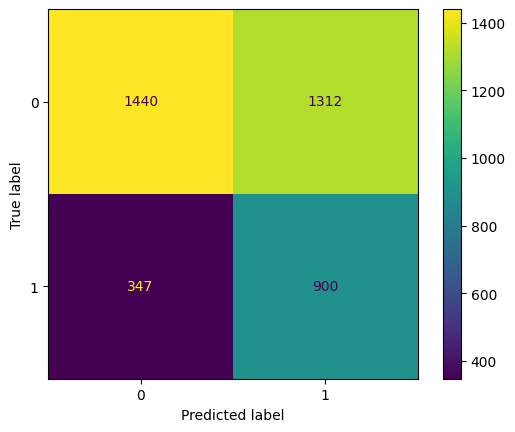

In [47]:
CM_original = (evaluations_original[0][3] + evaluations_original[1][3] + evaluations_original[2][3] + evaluations_original[3][3] + evaluations_original[4][3]) // 5
CM_3_10 = (evaluations_3_10[0][3] + evaluations_3_10[1][3] + evaluations_3_10[2][3] + evaluations_3_10[3][3] + evaluations_3_10[4][3]) // 5
CM_equally = (evaluations_equally[0][3] + evaluations_equally[1][3] + evaluations_equally[2][3] + evaluations_equally[3][3] + evaluations_equally[4][3]) // 5

cm = CM_original

TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
TP = cm[1, 1]

accuracy = (TP + TN) / (TP + TN + FP + FN)

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
balanced_accuracy = (sensitivity + specificity) / 2

print(accuracy)
print(balanced_accuracy)

disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=CM_equally,
                              display_labels=[0, 1])
disp.plot()
plt.show()

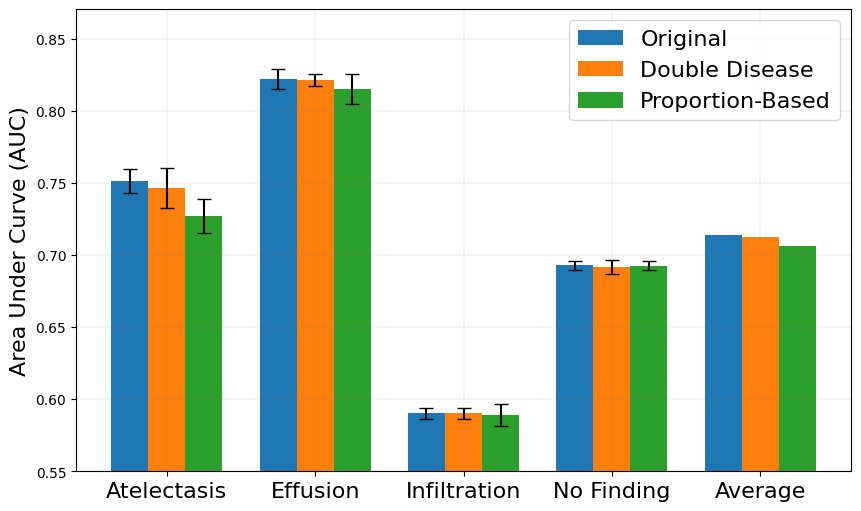

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

original_at, original_ef, original_in, original_nf = [], [], [], []
for eval in evaluations_original.values():
    original_at.append(eval[0][0])
    original_ef.append(eval[0][1])
    original_in.append(eval[0][2])
    original_nf.append(eval[0][3])
original_means = {param: np.mean(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [original_at, original_ef, original_in, original_nf])}
original_stds = {param: np.std(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [original_at, original_ef, original_in, original_nf])}

horizontal_at, horizontal_ef, horizontal_in, horizontal_nf = [], [], [], []
for eval in evaluations_original_cw_2.values():
    horizontal_at.append(eval[0][0])
    horizontal_ef.append(eval[0][1])
    horizontal_in.append(eval[0][2])
    horizontal_nf.append(eval[0][3])
horizontal_means = {param: np.mean(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [horizontal_at, horizontal_ef, horizontal_in, horizontal_nf])}
horizontal_stds = {param: np.std(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [horizontal_at, horizontal_ef, horizontal_in, horizontal_nf])}

translation_at, translation_ef, translation_in, translation_nf = [], [], [], []
for eval in evaluations_original_cw.values():
    translation_at.append(eval[0][0])
    translation_ef.append(eval[0][1])
    translation_in.append(eval[0][2])
    translation_nf.append(eval[0][3])
translation_means = {param: np.mean(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [translation_at, translation_ef, translation_in, translation_nf])}
translation_stds = {param: np.std(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [translation_at, translation_ef, translation_in, translation_nf])}

performance = np.array([[original_means['at'], original_means['ef'], original_means['in'], original_means['nf']],
                        [horizontal_means['at'], horizontal_means['ef'], horizontal_means['in'], horizontal_means['nf']],
                        [translation_means['at'], translation_means['ef'], translation_means['in'], translation_means['nf']]])
row_averages = np.mean(performance, axis=1)


performance = np.column_stack((performance, row_averages))

std_dev = np.array([[original_stds['at'], original_stds['ef'], original_stds['in'], original_stds['nf'], np.NaN],
                    [horizontal_stds['at'], horizontal_stds['ef'], horizontal_stds['in'], horizontal_stds['nf'], np.NaN],
                    [translation_stds['at'], translation_stds['ef'], translation_stds['in'], translation_stds['nf'], np.NaN]])

labels = ['Atelectasis', 'Effusion', 'Infiltration', 'No Finding', 'Average']
model_names = ['Original', '10K / 3.33K', 'Equal']
model_names = ['Original', 'Double Disease', 'Proportion-Based']
n_models = len(model_names)
n_labels = len(labels)

font_size = 16

x = np.arange(n_labels)  # positions of the labels
width = 0.25  # width of each bar, smaller to fit all models in each label group

# Create a plot
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(n_models):
    ax.bar(x + i * width, performance[i], width, yerr=std_dev[i], label=model_names[i], capsize=5)

ax.set_xticks(x + width * (n_models - 1) / 2)  # Place the x-ticks in the middle of the grouped bars
ax.set_xticklabels(labels, fontsize=font_size)
ax.legend(fontsize=font_size, loc="upper right")
ax.set_ylim(0.55)
ax.set_ylabel("Area Under Curve (AUC)", fontsize=font_size)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

# plt.savefig("evals/augmentation/geometricAll_20epochs_5runs_ES.pdf", bbox_inches='tight', pad_inches=0)

plt.show()

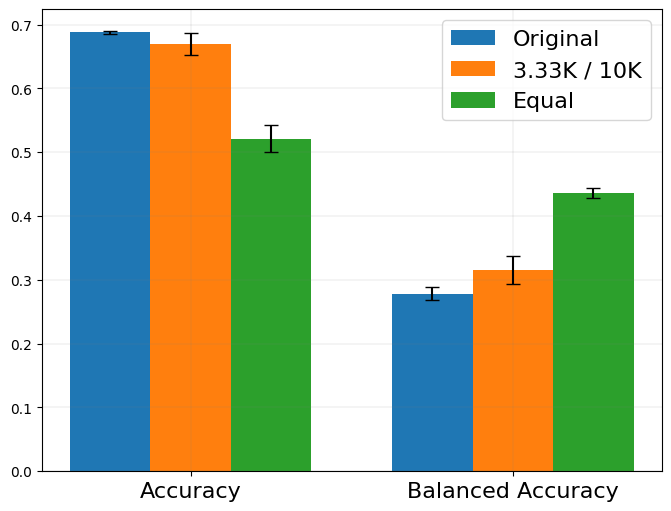

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

original_at, original_ef, original_in, original_nf = [], [], [], []
for eval in evaluations_original.values():
    original_ef.append(eval[2])
    original_in.append(eval[1])
original_means = {param: np.mean(values) for param, values in zip(['ef', 'in'], [original_ef, original_in])}
original_stds = {param: np.std(values) for param, values in zip(['ef', 'in'], [original_ef, original_in])}

horizontal_at, horizontal_ef, horizontal_in, horizontal_nf = [], [], [], []
for eval in evaluations_original_cw_2.values():
    horizontal_ef.append(eval[2])
    horizontal_in.append(eval[1])
horizontal_means = {param: np.mean(values) for param, values in zip(['ef', 'in'], [horizontal_ef, horizontal_in])}
horizontal_stds = {param: np.std(values) for param, values in zip(['ef', 'in'], [horizontal_ef, horizontal_in])}

translation_at, translation_ef, translation_in, translation_nf = [], [], [], []
for eval in evaluations_original_cw.values():
    translation_ef.append(eval[2])
    translation_in.append(eval[1])
translation_means = {param: np.mean(values) for param, values in zip(['ef', 'in'], [translation_ef, translation_in])}
translation_stds = {param: np.std(values) for param, values in zip(['ef', 'in'], [translation_ef, translation_in])}

performance = np.array([[original_means['ef'], original_means['in']],
                        [horizontal_means['ef'], horizontal_means['in']],
                        [translation_means['ef'], translation_means['in']]])

std_dev = np.array([[original_stds['ef'], original_stds['in']],
                    [horizontal_stds['ef'], horizontal_stds['in']],
                    [translation_stds['ef'], translation_stds['in']]])

labels = ['Accuracy', 'Balanced Accuracy']
model_names = ['Original', '3.33K / 10K', 'Equal']
n_models = len(model_names)
n_labels = len(labels)

font_size = 16

x = np.arange(n_labels)  # positions of the labels
width = 0.25  # width of each bar, smaller to fit all models in each label group

# Create a plot
fig, ax = plt.subplots(figsize=(8, 6))

for i in range(n_models):
    ax.bar(x + i * width, performance[i], width, yerr=std_dev[i], label=model_names[i], capsize=5)

ax.set_xticks(x + width * (n_models - 1) / 2)  # Place the x-ticks in the middle of the grouped bars
ax.set_xticklabels(labels, fontsize=font_size)
ax.legend(fontsize=font_size, loc="best")
# ax.set_ylim(0.55)
# ax.set_ylabel("Area Under Curve (AUC)", fontsize=font_size)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

# plt.savefig("evals/augmentation/geometricAll_20epochs_5runs_ES.pdf", bbox_inches='tight', pad_inches=0)

plt.show()